# The 2021 Italian Grand Prix

### “Would Ricciardo Have Beaten Verstappen on Merit During the Italian GP?”


That is a question I have seen come across a lot. Unfortunately, we never got to find out the answer because — as we all know — Hamilton and Verstappen collided. What we can do, however, is have a look at the data of some laps from before the crash, and ask ourselves whether Verstappen would have been able to pass Ricciardo during later stints.

This tutorial will dive into **telemetry data**. It will also show you how to use and process the available distance variables between Ricciardo and Verstappen, which requires some different approaches and some data transformations.

## Step 1 : Set up the basics

In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

# Enable the cache
ff1.Cache.enable_cache('/home/ilazza/Documenti/Formula1_Data_Analysis/cache') 

# Setup plotting
plotting.setup_mpl()

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

## Step 2 : Collect the data

We start by loading the full session data by passing the year as the first parameter, the location as the second parameter and the session as the third parameter (this one could, for example, also be ‘Q’ if we want 'Quali').

In [2]:
# Load the session data
race = ff1.get_session(2021 , "Monza" , 'R')

#Get the laps including telemetry
laps = race.load_laps(with_telemetry=True)

#Selecting only the one in which we are interested in (Verstappen and Ricciardo)
laps_ric = laps.pick_driver('RIC')
laps_ver = laps.pick_driver('VER')


core           INFO 	Loading laps for Italian Grand Prix - Race [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['22', '5', '4', '88', '55', '3', '10', '33', '11', '6', '77', '18', '63', '99', '47', '9', '44', '31', '16', '14']


Since Verstappen and Hamilton crashed right after the pitstops and the close battle between Verstappen and Ricciardo was mainly happening during their first stint, we only select the first stint:


In [3]:
#Only analyzing stint 1, so select that one

laps_ric = laps_ric.loc[laps_ric['Stint'] == 1]
laps_ver = laps_ver.loc[laps_ver['Stint'] == 1]

## Expanding the data

Now we have loaded all our data, we want to run some calculations and transformations on them to prepare for our analyses.


First, we quickly create a variable for the race lap number. 
The difference between the race lap and the “actual” lap is that the latter also includes the warm up lap. Since the race started in lap 2 because lap 1 was the warm up lap, we subtract 1.

In [4]:
laps_ric['RaceLapNumber'] = laps_ric['LapNumber'] -1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] -1

Now, however, we are going to do some more complicated stuff. The thing we want to achieve is to get an idea of how close Verstappen was during the laps. To do so, the fastf1 telemetry data can provide us with the distance to the driver ahead.
We are therefore only interested in the telemetry of Verstappen, since he driving behind Ricciardo. 

So, let’s create two DataFrames: one for all the distances between Verstappen and Ricciardo at any moment during any lap, and one for the average (summarized) distance per lap.

In [5]:
full_distance_ver_ric = pd.DataFrame()
summarized_distance_ver_ric = pd.DataFrame()

Next, what we need to do is loop through all the laps one by one. The reason we do this is because if we don’t, the ‘Distance’ variable in the telemetry data will range from 0 meters until the entire length of the first stint (which is about 23 laps, so over 130km). 

However, we don’t want that, since we want to compare lap-by-lap. In other words, the telemetry data needs to be requested again and again to reset the distance variable to 0.

In [6]:
for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
# Only run this loop when driver ahead is RIC, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "3"]
    
    if len(telemetry) != 0:
        #Full distance
        lap_telemetry  = telemetry[['Distance' , 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] +1
        
        full_distance_ver_ric = full_distance_ver_ric.append(lap_telemetry)
        
        #Average / median  Distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])
        
        summarized_distance_ver_ric = summarized_distance_ver_ric.append({
            'Lap' :  lap[0] +1,
            'Mean' : distance_mean,
            'Median' : distance_median
        }, ignore_index = True)

- **[Line 1]** First, as mentioned above, we loop through all Verstappen’s laps one by one. Fastf1 has a built-in function to iterate through laps, which is called iterlaps() . It basically is similar to Pandas’ iterrows() .


- **[Line 2]** Then, we create the telemetry variable. We select the lap data, tell fastf1 to load the car data (so the telemetry), tell fastf1 to include the distance that has been driven into the lab, and lastly, tell fastf1 to add the driver ahead. That last thing will do two things: add a column DriverAhead and add a column DistanceToDriverAhead to the telemetry data of Verstappen.


- **[Line 5]** We then only select telemetry from when the DriverAhead was number 3, since we’re only interested in Verstappen’s battle with Ricciardo (car number 3).


- **[Line 7]** We quickly check if the telemetry DataFrame is not empty. If it is empty, this means that the driver ahead is not Ricciardo (e.g. during the pitstops) so we don’t want to include that telemetry data.


- **[Lines 8–12]** We then select the columns we want for the full distance DataFrame, and include the lap number with it so we can compare all the laps and all the distances later on.


- **[Lines 14–22]** We then calculate the summary statistics for the distances per lap. We want the average and the median distance for the laps, so we can compare those later as well. The method np.nanmean() automatically ignores all NaN values, which is convenient for us. The reason we do this is because sometimes there is no driver in front (like during pitstops), which will result in a NaN value.

In [18]:
prova = laps_ric['LapTime']
print(prova[40].total_seconds())

86.628


## Plotting the data

To evaluate the battle between Verstappen and Ricciardo, let’s first start with comparing their lap times and the average distance between them (which we just calculated!).

### Laptimes and distance

To do so, we use the `subplots` functionality from matplotlib. This allows us to create multiple plots in one single figure. The first subplot consists of the lap times during the opening stint, while the second subplot will show us the average distance between Verstappen and Ricciardo.


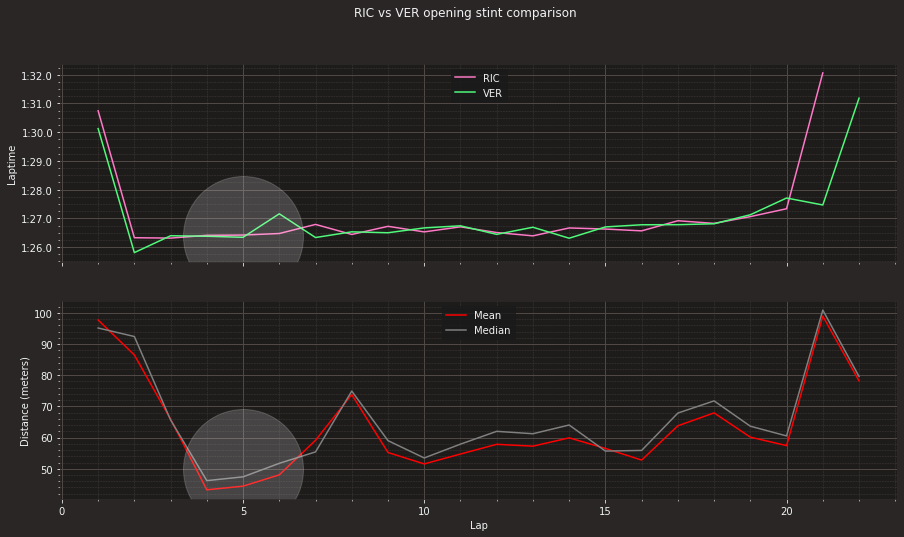

In [48]:
plt.rcParams['figure.figsize'] = [15, 8]

fig, ax = plt.subplots(2)
fig.suptitle("RIC vs VER opening stint comparison")


ax[0].plot(laps_ric['RaceLapNumber'], laps_ric['LapTime'], label='RIC')
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER')
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")
ax[0].plot(5,0.001,marker='o',ms=120,mfc='w',mec='w', alpha=0.18)



ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")
ax[1].plot(5,50,marker='o',ms=120,mfc='w', mec='w', alpha=0.18)



# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()

 Verstappen was really close during laps 4, 5 and 6. 
 Their lap times were almost similar, meaning he was really pushing to get close and probably had some overspeed. However, as we all know, the closer you get, the more difficult it is to follow. If you are chasing another driver, you suffer from dirty air and your tires will start overheating.

### Lap 4 telemetry

Since Verstappen was closest during lap 4, let’s analyse the telemetry of that lap. To provide some context, we will also include the distance between Verstappen and Ricciardo from across the lap of laps 3, 4, 5 and 6.

In [8]:
# Get lap data

lap_telemetry_ric = laps_ric.loc[laps_ric['RaceLapNumber']==4].get_car_data().add_distance()
lap_telemetry_ver = laps_ver.loc[laps_ver['RaceLapNumber']==4].get_car_data().add_distance()

distance_lap3 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==3]
distance_lap4 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==4]
distance_lap5 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==5]
distance_lap6 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==6]

So, to begin, we select the telemetry from both Ricciardo and Verstappen of lap 4 (and we use the previously created variable `RaceLapNumber` ). As before, we run `get_car_data()` and `add_distance()` to include the telemetry and the distance that has been driven during the lap. Next to that, we select the distances between the drivers from lap 3 until 6 from the variable `full_distance_ver_ric`

This variable contains all the distances at any given moment within a lap (play around with this yourself to fully understand what the data looks like).

Now we have to plot

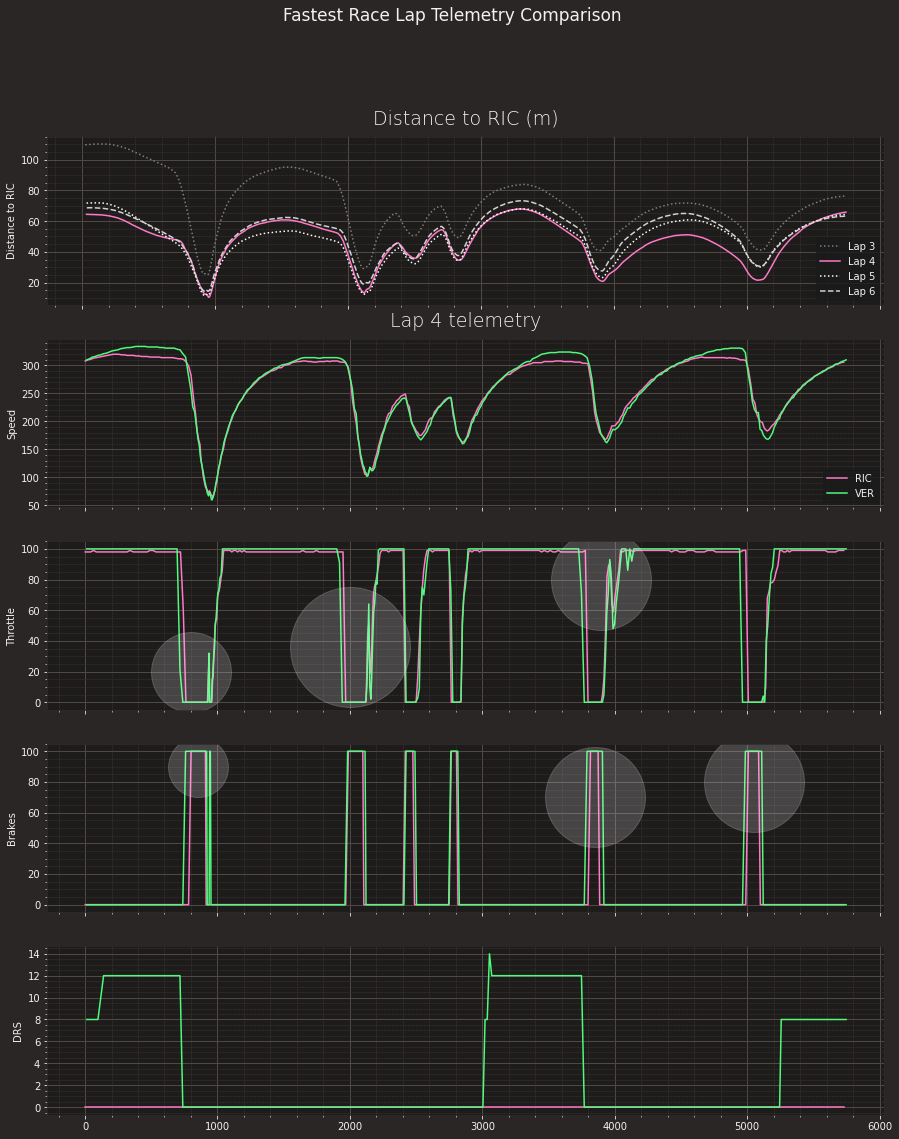

In [9]:


plt.rcParams['figure.figsize'] = [15, 18]

fig, ax = plt.subplots(5)
fig.suptitle("Fastest Race Lap Telemetry Comparison" , fontsize=17)

ax[0].title.set_text("Distance to RIC (m)")
ax[0].plot(distance_lap3['Distance'], distance_lap3['DistanceToDriverAhead'], label='Lap 3', linestyle='dotted', color='grey')
ax[0].plot(distance_lap4['Distance'], distance_lap4['DistanceToDriverAhead'], label='Lap 4')
ax[0].plot(distance_lap5['Distance'], distance_lap5['DistanceToDriverAhead'], label='Lap 5', linestyle='dotted', color='white')
ax[0].plot(distance_lap6['Distance'], distance_lap6['DistanceToDriverAhead'], label='Lap 6', linestyle='dashed', color='lightgrey')
ax[0].legend(loc="lower right")
ax[0].set(ylabel='Distance to RIC')

ax[1].title.set_text("Lap 4 telemetry")
ax[1].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Speed'], label='RIC')
ax[1].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Speed'], label='VER')
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")

ax[2].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Throttle'], label='RIC')
ax[2].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Throttle'], label='VER')
ax[2].set(ylabel='Throttle')
ax[2].plot(800,20,marker='o',ms=80,mfc='w',mec='w', alpha=0.18)
ax[2].plot(2000,36,marker='o',ms=120,mfc='w',mec='w', alpha=0.18)
ax[2].plot(3900,80,marker='o',ms=100,mfc='w',mec='w', alpha=0.18)



ax[3].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Brake'], label='RIC')
ax[3].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Brake'], label='VER')
ax[3].set(ylabel='Brakes')
ax[3].plot(850,90,marker='o',ms=60,mfc='w',mec='w', alpha=0.18)
ax[3].plot(3850,70,marker='o',ms=100,mfc='w',mec='w', alpha=0.18)
ax[3].plot(5055,80,marker='o',ms=100,mfc='w',mec='w', alpha=0.18)


ax[4].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['DRS'], label='RIC')
ax[4].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['DRS'], label='VER')
ax[4].set(ylabel='DRS')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()

The first subplot shows us the distance between the drivers during lap 3–6, with the main focus on lap 4 where Verstappen was closest. Then, we show all the telemetry of lap 4, where we can see what actually causes the distance between Verstappen and Ricciardo to increase and decrease.


So, now things are becoming intresting. First of all, we can see in the first subplot that Verstappen was really close for a few laps, and actually very close to overtaking Ricciardo into T1 and T3. If you look at the distance during lap 3 compared to the distance during lap 4, you can see that Verstappen actually left much more room between Ricciardo in for example T2 (Curva Grande). This shows that Verstappen was really pushing during lap 4, 5 and 6.


When analyzing the telemetry of lap 4, we can see a few interesting things happen. All of the circles indicate that verstappen was really struggling in the Ricciardo’s dirty air, forcing him to make corrections. For example, when exiting T1, verstappen had to correct his throttle appliance and apply the brakes for a brief moment, probably leaving a few tenths on the table. Also, during the end of the lap, Verstappen had to break earlier than Ricciardo, while he also had to brake for a longer period of time than Ricciardo. It is also really visible from the throttle input that Verstappen really struggled when going through the high-speed corner Ascari.


## Conclusion

Let’s go back to the starting question

### “Would Ricciardo Have Beaten Verstappen on Merit During the Italian GP?”


I would say: **yes**. When looking at the data we just analyzed, it was really hard to follow and stay close to Ricciardo. Apparently, Verstappen was really pushing at some points during the opening stint. The McLaren’s Mercedes engine, however, was just too strong for the Red Bull to pass on the straights. I guess Verstappen had a bit more overspeed and would have pulled away if he managed to pass Ricciardo, but the nature of the Monza circuit made it just really difficult to get by.



**However…** I am not sure. What if Verstappens pitstop would have been really fast? What if the Red Bull was stronger on the Hards than on the Mediums? What if Hamilton joined the fight for the race win? We don’t know. All I can say is that the McLarens looked really strong, and I think that even without Verstappen’s crash they would have had a good chance of getting the race win.
